In [1]:
# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('viridis')

# Parameters for the visualizations
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# For easy computation over certain datasets
import numpy as np
np.set_printoptions(suppress=True)

# Pyspark utilities
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

# Execution mode:
# Cluster = -1
# Local >= 1 (i.e., number of files to load)

EXEC_MODE = 1
cloud = False

# TODO
from lib import *

# start spark with 1 worker thread
sc = init()
sc.setLogLevel("ERROR")

# Start SparkSession to use DataFrames
spark = SparkSession(sc)

In [2]:
# Same as above, load a part of the table in memory and use it.
task_events = Table('task_events', sc, EXEC_MODE, cloud)

In [3]:
task_events.pprint(2)

,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,5611824441,NA,6251812952,1761,1306108,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.07959,0.0003862,1
1,5611824625,NA,6251974185,252,38676295,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.03339,0.0003862,1


In [4]:
task_usage = Table('task_usage', sc, EXEC_MODE, cloud)

In [5]:
# Select first SUBMIT transition for each job
submit_status = task_events.select(['job_id','event_type', 'time'])\
    .filter(lambda x: x[1] in ['0'])\
    .map(lambda x: (x[0], float(x[2])))

rdd_submit = submit_status.groupByKey().mapValues(lambda x: round(sum(x)/len(x), 3))
rdd_submit.take(5)

[('6114773114', 1739339457.944),
 ('515042954', 6971841280.75),
 ('6251699911', 4205796292.046),
 ('5390365067', 3241352783.11),
 ('6252020538', 5638258761.0)]

In [6]:
# Select first OUT transition for each job
outpending_status = task_events.select(['job_id','event_type', 'time'])\
    .filter(lambda x: x[1] in ['1', '3', '5', '6'])\
    .map(lambda x: (x[0], float(x[2])))

rdd_out = outpending_status.groupByKey().mapValues(lambda x: round(sum(x)/len(x), 3))
rdd_out.take(5)

[('515042954', 7928689887.113),
 ('5390365067', 4938707935.26),
 ('6252018951', 5638258848.0),
 ('6252020683', 5638258900.0),
 ('6251625636', 7048885779.576)]

In [7]:
rdd_deltatimes = rdd_submit.join(rdd_out).map(lambda x: (x[0], x[1][1] - x[1][0]))

rdd_deltatimes.take(10)

[('6114773114', 1323652.0369999409),
 ('515042954', 956848606.3629999),
 ('6251699911', 5176036.414000034),
 ('5390365067', 1697355152.15),
 ('6252020538', 3129406604.6100006),
 ('5402488769', 2518577.0929999948),
 ('6251994764', 1723018.0),
 ('6252024742', 50658802.53299999),
 ('6252024798', 13294055.232999802),
 ('6251994475', 1419532.0)]

In [8]:
# Load the task_constraints table
task_constraints = Table('task_constraints', sc, EXEC_MODE, cloud)

In [9]:
# Selects each occurence of constraint registered for each process
task_constraints_per_job = task_constraints.select(['job_id'])\
    .map(lambda x: (x[0],1))\
    .reduceByKey(lambda a,b: a+b)
task_constraints_per_job.take(5)


[('3418314', 8),
 ('3418368', 12),
 ('3418375', 12),
 ('3418380', 8),
 ('3418400', 8)]

In [10]:
# Join the delta time and the number of constraints in one RDD
rdd_delta_constraints = rdd_deltatimes.join(task_constraints_per_job).filter(lambda x: x[1][1] < 50)
rdd_delta_constraints.take(5)


[('5390365067', (1697355152.15, 20)),
 ('3418380', (0.0, 8)),
 ('3418442', (0.0, 16)),
 ('6590376', (0.0, 8)),
 ('39308688', (0.0, 4))]

Text(0.5, 1.0, 'Time spent on PENDING state depending on the number of constraints')

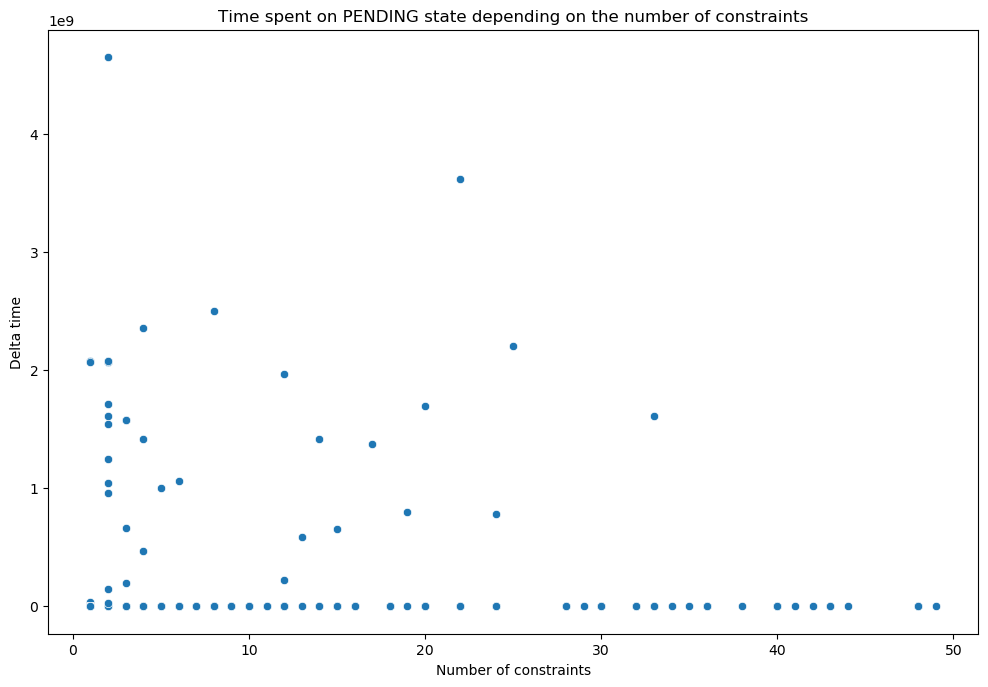

In [11]:
# Create the list of values from the last RDD
rdd_to_map = rdd_delta_constraints.collectAsMap()
deltatimes = [v[0] for v in rdd_to_map.values()]
constraints = [v[1] for v in rdd_to_map.values()]

# And then pass it to seaborn to create a barplot to have a global view
g = sns.scatterplot(x=constraints, y=deltatimes)

g.set_xlabel("Number of constraints")
g.set_ylabel("Delta time")

g.set_title("Time spent on PENDING state depending on the number of constraints")